# import data

In [1]:
import numpy as np
train_seismic = np.load('train/train_seismic.npy')
train_labels = np.load('train/train_labels.npy')
test_seismic = np.load('test_once/test1_seismic.npy')
test_labels = np.load('test_once/test1_labels.npy')

The value of pixels in edge will be zero if you expand the section's edge

In [3]:
train_labels+=1
test_labels+=1

# 2.Make the patches of 3-D seismic data

## Define the function

In [4]:
def seispatch_2d(section,patch_size,os_x=0,os_y=0,show=0,colors="Dark2"):
    '''
    section :the 2-D seismic data
    patch_size :the size of patches
    os_x/_y: the length of overlap 
    show: 1:visualization
    colors：if show==1; label:"Dark2"; seismic:"seismic" or "Greys"
    '''
    m1,m2 = section.shape                            
    n1,n2 = patch_size,patch_size              

    c1 = int(np.round((m1+os_y)/(n1-os_y)+0.5))   
    c2 = int(np.round((m2+os_x)/(n2-os_x)+0.5))-1

    p1 = (n1-os_y)*c1+os_y   #expand the edge
    p2 = (n2-os_x)*c2+os_x   

    img_pad   = np.zeros((p1,p2),dtype=np.single)
    img_pad[0:m1,0:m2]=section
    img_patch = np.zeros((n1,n2),dtype=np.single)

    i=0
    result=np.zeros((c1*c2,n1,n2),dtype=np.single)  #结果储存进矩阵
    
    for k1 in range(c1):
        for k2 in range(c2):
            b1 = k1*(n1-os_y)  #开始：n1-os=116
            e1 = b1+n1          
            b2 = k2*(n2-os_x)
            e2 = b2+n2                   
            img_patch=img_pad[b1:e1,b2:e2]
            result[i,]=img_patch
            i+=1
            
            if show == 1:
                import matplotlib.pyplot as plt
                plt.subplot(c1,c2,i)
                imgplot1 = plt.imshow(img_patch,cmap=colors,interpolation='nearest')            
    return result

def extract_2d_from_3d(seismic_3d,axis=0,patch_size=128,os_x=0,os_y=0):
    '''
    seismic_3d :the 3-D seismic data
    axis :0:patch from inline; 1:xline
    '''
    for i in range(np.shape(seismic_3d)[axis]):
        line=seispatch_2d(np.transpose(seismic_3d[i]),patch_size,os_x,os_y)
        if i == 0:
            c = line
        else:
            c=np.vstack((c,line))
    return c

(5, 256, 256)

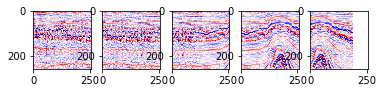

In [6]:
import matplotlib.pyplot as plt
line1=seispatch_2d(np.transpose(train_seismic[400]),256,128,pic=1,colors="seismic_r")
line1.shape

## make the training data sets

In [9]:
sei_patch = extract_2d_from_3d(train_seismic,patch_size=256,os=128)
lab_patch = extract_2d_from_3d(train_labels,patch_size=256,os=128)
lab_patch.shape

(2005, 256, 256)

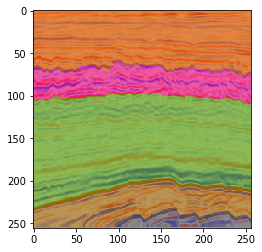

In [10]:
n=970
plt.imshow(sei_patch[n],cmap="seismic_r")
plt.imshow(lab_patch[n],cmap="Dark2",alpha=0.75)

## make the validation data sets

In [11]:
test_sei_patch = extract_2d_from_3d(test_seismic,patch_size=256,os=128)
test_lab_patch = extract_2d_from_3d(test_labels,patch_size=256,os=128)
test_sei_patch.shape

(1000, 256, 256)

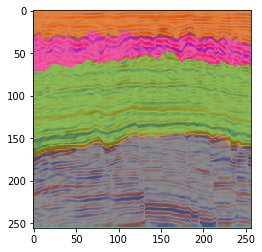

In [12]:
n=20
plt.imshow(test_sei_patch[n],cmap="seismic_r")
plt.imshow(test_lab_patch[n],cmap="Dark2",alpha=0.75)

# 3.PNP-net architecture 

In [ ]:
from __future__ import print_function
from math import ceil
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization, Activation, Input, Dropout, ZeroPadding2D, Lambda
from keras.layers.merge import Concatenate, Add
from keras.models import Model
from keras.optimizers import Adam
from keras.backend import tf as ktf

import tensorflow as tf


def BN(name=""):
    return BatchNormalization(momentum=0.95, name=name, epsilon=1e-5)


class Interp(layers.Layer):

    def __init__(self, new_size, **kwargs):
        self.new_size = new_size
        super(Interp, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Interp, self).build(input_shape)

    def call(self, inputs, **kwargs):
        new_height, new_width = self.new_size
        resized = ktf.image.resize_images(inputs, [new_height, new_width],
                                          align_corners=True)
        return resized

    def compute_output_shape(self, input_shape):
        return tuple([None, self.new_size[0], self.new_size[1], input_shape[3]])

    def get_config(self):
        config = super(Interp, self).get_config()
        config['new_size'] = self.new_size
        return config

def residual_conv(prev, level, pad=1, lvl=1, sub_lvl=1, modify_stride=False):
    lvl = str(lvl)
    sub_lvl = str(sub_lvl)
    names = ["conv" + lvl + "_" + sub_lvl + "_1x1_reduce",
             "conv" + lvl + "_" + sub_lvl + "_1x1_reduce_bn",
             "conv" + lvl + "_" + sub_lvl + "_3x3",
             "conv" + lvl + "_" + sub_lvl + "_3x3_bn",
             "conv" + lvl + "_" + sub_lvl + "_1x1_increase",
             "conv" + lvl + "_" + sub_lvl + "_1x1_increase_bn"]
    if modify_stride is False:
        prev = Conv2D(64 * level, (1, 1), strides=(1, 1), name=names[0],
                      use_bias=False)(prev)
    elif modify_stride is True:
        prev = Conv2D(64 * level, (1, 1), strides=(2, 2), name=names[0],
                      use_bias=False)(prev)

    prev = BN(name=names[1])(prev)
    prev = Activation('relu')(prev)

    prev = ZeroPadding2D(padding=(pad, pad))(prev)
    prev = Conv2D(64 * level, (3, 3), strides=(1, 1), dilation_rate=pad,
                  name=names[2], use_bias=False)(prev)

    prev = BN(name=names[3])(prev)
    prev = Activation('relu')(prev)
    prev = Conv2D(256 * level, (1, 1), strides=(1, 1), name=names[4],
                  use_bias=False)(prev)
    prev = BN(name=names[5])(prev)
    return prev


def short_convolution_branch(prev, level, lvl=1, sub_lvl=1, modify_stride=False):
    lvl = str(lvl)
    sub_lvl = str(sub_lvl)
    names = ["conv" + lvl + "_" + sub_lvl + "_1x1_proj",
             "conv" + lvl + "_" + sub_lvl + "_1x1_proj_bn"]

    if modify_stride is False:
        prev = Conv2D(256 * level, (1, 1), strides=(1, 1), name=names[0],
                      use_bias=False)(prev)
    elif modify_stride is True:
        prev = Conv2D(256 * level, (1, 1), strides=(2, 2), name=names[0],
                      use_bias=False)(prev)

    prev = BN(name=names[1])(prev)
    return prev


def empty_branch(prev):
    return prev


def residual_short(prev_layer, level, pad=1, lvl=1, sub_lvl=1, modify_stride=False):
    prev_layer = Activation('relu')(prev_layer)
    block_1 = residual_conv(prev_layer, level,
                            pad=pad, lvl=lvl, sub_lvl=sub_lvl,
                            modify_stride=modify_stride)

    block_2 = short_convolution_branch(prev_layer, level,
                                       lvl=lvl, sub_lvl=sub_lvl,
                                       modify_stride=modify_stride)
    added = Add()([block_1, block_2])
    return added


def residual_empty(prev_layer, level, pad=1, lvl=1, sub_lvl=1):
    prev_layer = Activation('relu')(prev_layer)

    block_1 = residual_conv(prev_layer, level, pad=pad,
                            lvl=lvl, sub_lvl=sub_lvl)
    block_2 = empty_branch(prev_layer)
    added = Add()([block_1, block_2])
    return added


def ResNet(inp, layers):
    # Names for the first couple layers of model
    names = ["conv1_1_3x3_s2",
             "conv1_1_3x3_s2_bn",
             "conv1_2_3x3",
             "conv1_2_3x3_bn",
             "conv1_3_3x3",
             "conv1_3_3x3_bn"]

    # Short branch(only start of network)

    cnv1 = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name=names[0],
                  use_bias=False)(inp)  # "conv1_1_3x3_s2"
    bn1 = BN(name=names[1])(cnv1)  # "conv1_1_3x3_s2/bn"
    relu1 = Activation('relu')(bn1)  # "conv1_1_3x3_s2/relu"

    cnv1 = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name=names[2],
                  use_bias=False)(relu1)  # "conv1_2_3x3"
    bn1 = BN(name=names[3])(cnv1)  # "conv1_2_3x3/bn"
    relu1 = Activation('relu')(bn1)  # "conv1_2_3x3/relu"

    cnv1 = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name=names[4],
                  use_bias=False)(relu1)  # "conv1_3_3x3"
    bn1 = BN(name=names[5])(cnv1)  # "conv1_3_3x3/bn"
    relu1 = Activation('relu')(bn1)  # "conv1_3_3x3/relu"

    res = MaxPooling2D(pool_size=(3, 3), padding='same',
                       strides=(2, 2))(relu1)  # "pool1_3x3_s2"

    # ---Residual layers(body of network)

    """
    Modify_stride --Used only once in first 3_1 convolutions block.
    changes stride of first convolution from 1 -> 2
    """

    # 2_1- 2_3
    res = residual_short(res, 1, pad=1, lvl=2, sub_lvl=1)
    for i in range(2):
        res = residual_empty(res, 1, pad=1, lvl=2, sub_lvl=i + 2)

    # 3_1 - 3_3
    res = residual_short(res, 2, pad=1, lvl=3, sub_lvl=1, modify_stride=True)
    for i in range(3):
        res = residual_empty(res, 2, pad=1, lvl=3, sub_lvl=i + 2)
    if layers is 50:
        # 4_1 - 4_6
        res = residual_short(res, 4, pad=2, lvl=4, sub_lvl=1)
        for i in range(5):
            res = residual_empty(res, 4, pad=2, lvl=4, sub_lvl=i + 2)
    elif layers is 101:
        # 4_1 - 4_23
        res = residual_short(res, 4, pad=2, lvl=4, sub_lvl=1)
        for i in range(22):
            res = residual_empty(res, 4, pad=2, lvl=4, sub_lvl=i + 2)
    else:
        print("This ResNet is not implemented")

    # 5_1 - 5_3
    res = residual_short(res, 8, pad=4, lvl=5, sub_lvl=1)
    for i in range(2):
        res = residual_empty(res, 8, pad=4, lvl=5, sub_lvl=i + 2)

    res = Activation('relu')(res)
    return res


def interp_block(prev_layer, level, feature_map_shape, input_shape):
    if input_shape == (256, 256):
        kernel_strides_map = {1: 60,
                              2: 30,
                              3: 20,
                              6: 10}
    else:
        print("Pooling parameters for input shape ",
              input_shape, " are not defined.")
        exit(1)

    names = [
        "conv5_3_pool" + str(level) + "_conv",
        "conv5_3_pool" + str(level) + "_conv_bn"
    ]
    kernel = (kernel_strides_map[level], kernel_strides_map[level])
    strides = (kernel_strides_map[level], kernel_strides_map[level])
    prev_layer = AveragePooling2D(kernel, strides=strides)(prev_layer)
    prev_layer = Conv2D(512, (1, 1), strides=(1, 1), name=names[0],
                        use_bias=False)(prev_layer)
    prev_layer = BN(name=names[1])(prev_layer)
    prev_layer = Activation('relu')(prev_layer)
    # prev_layer = Lambda(Interp, arguments={
    #                    'shape': feature_map_shape})(prev_layer)
    prev_layer = Interp(feature_map_shape)(prev_layer)
    return prev_layer


def build_pyramid_pooling_module(res, input_shape):
    """Build the Pyramid Pooling Module."""
    # ---PSPNet concat layers with Interpolation
    feature_map_size = tuple(int(ceil(input_dim / 4.0))
                             for input_dim in input_shape)
    print("PSP module will interpolate to a final feature map size of %s" %
          (feature_map_size, ))

    interp_block1 = interp_block(res, 1, feature_map_size, input_shape)
    interp_block2 = interp_block(res, 2, feature_map_size, input_shape)
    interp_block3 = interp_block(res, 3, feature_map_size, input_shape)
    interp_block6 = interp_block(res, 6, feature_map_size, input_shape)

    # concat all these layers. resulted
    # shape=(1,feature_map_size_x,feature_map_size_y,4096)
    res = Concatenate()([res,
                         interp_block6,
                         interp_block3,
                         interp_block2,
                         interp_block1])
    return res


def build_pspnet(nb_classes, resnet_layers, input_shape, activation='softmax'):
    """Build PSPNet."""
    print("Building a PSPNet based on ResNet %i expecting inputs of shape %s predicting %i classes" % (
        resnet_layers, input_shape, nb_classes))

    inp = Input((input_shape[0], input_shape[1], 1))
    res = ResNet(inp, layers=resnet_layers)
    psp = build_pyramid_pooling_module(res, input_shape)

    x = Conv2D(512, (3, 3), strides=(1, 1), padding="same", name="conv5_4",
               use_bias=False)(psp)
    x = BN(name="conv5_4_bn")(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    x = Conv2D(nb_classes, (1, 1), strides=(1, 1), name="conv6")(x)

    x = Interp([input_shape[0], input_shape[1]])(x)
    x = Activation('softmax')(x)

    model = Model(inputs=inp, outputs=x)

    # Solver
    model.compile(Adam(lr = 1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
    return model


In [15]:
model=build_pspnet(7,50,(256,256))
model.summary()  

Building a PSPNet based on ResNet 50 expecting inputs of shape (256, 256) predicting 7 classes
PSP module will interpolate to a final feature map size of (64, 64)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv1_1_3x3_s2 (Conv2D)         (None, 256, 256, 64) 576         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_1_3x3_s2_bn (BatchNormali (None, 256, 256, 64) 256         conv1_1_3x3_s2[0][0]             
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 2

#  4.train

In [13]:
from keras.utils.np_utils import to_categorical
class DataGenerator(keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = to_categorical(batch_y, num_classes=7)
#        batch_y = batch_y.reshape(self.batch_size,128*128*128,6)
#        batch_y = np.expand_dims(batch_y,axis=4)

        return np.expand_dims(batch_x,axis=4), batch_y

training_generator=DataGenerator(x_set=sei_patch,y_set=lab_patch,batch_size=25)
validation_generator=DataGenerator(x_set=test_sei_patch,y_set=test_lab_patch,batch_size=25)

Using TensorFlow backend.


In [17]:
from keras import callbacks

K.set_image_data_format('channels_last')
model_name = 'facies'
model_dir     = os.path.join('check', model_name)
csv_fn        = os.path.join(model_dir, 'train_log.csv')
checkpoint_fn = os.path.join(model_dir, 'checkpoint.{epoch:02d}.hdf5')

checkpointer = callbacks.ModelCheckpoint(filepath=checkpoint_fn, verbose=1, save_best_only=False)

history = model.fit_generator(
                        generator=training_generator,
                        validation_data=validation_generator,
                        epochs=15,verbose=1,callbacks=[checkpointer])

Epoch 1/15


C:\Users\student\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


81/81 [==============================] - 46501s 574s/step - loss: 0.4172 - acc: 0.8816 - val_loss: 0.5204 - val_acc: 0.8475

Epoch 00001: saving model to check\facies\checkpoint.01.hdf5
Epoch 2/15
81/81 [==============================] - 46381s 573s/step - loss: 0.0742 - acc: 0.9712 - val_loss: 0.7070 - val_acc: 0.8157

Epoch 00002: saving model to check\facies\checkpoint.02.hdf5
Epoch 3/15
81/81 [==============================] - 48103s 594s/step - loss: 0.0552 - acc: 0.9782 - val_loss: 0.6518 - val_acc: 0.8420

Epoch 00003: saving model to check\facies\checkpoint.03.hdf5
Epoch 4/15
81/81 [==============================] - 45371s 560s/step - loss: 0.0468 - acc: 0.9813 - val_loss: 0.5070 - val_acc: 0.8651

Epoch 00004: saving model to check\facies\checkpoint.04.hdf5
Epoch 5/15
81/81 [==============================] - 45934s 567s/step - loss: 0.0414 - acc: 0.9832 - val_loss: 0.5028 - val_acc: 0.8730

Epoch 00005: saving model to check\facies\checkpoint.05.hdf5
Epoch 6/15
81/81 [========

In [20]:
# serialize model to JSON
model_json = model.to_json()
with open("model-pnp.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model-pnp.h5")

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


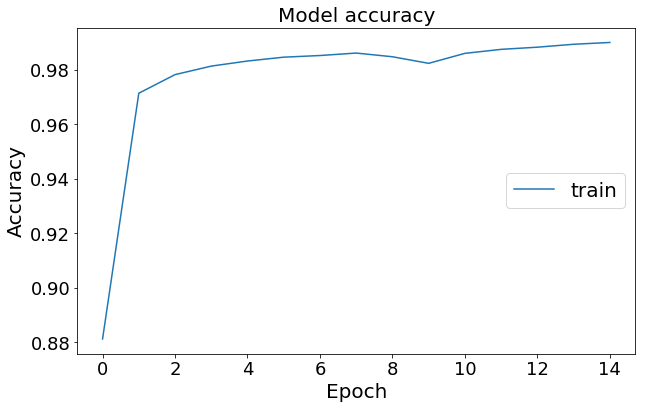

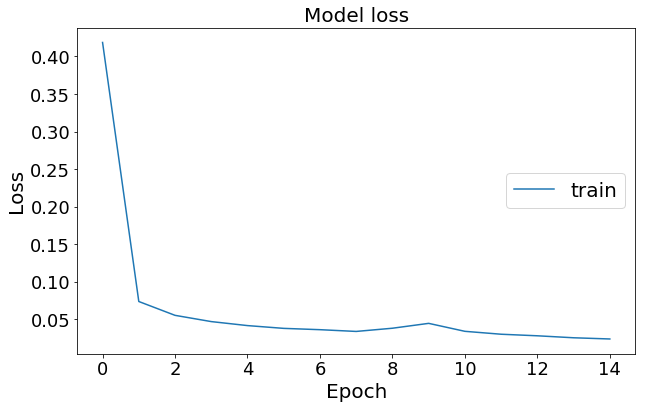

In [21]:
# list all data in history
print(history.history.keys())
fig = plt.figure(figsize=(10,6))

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('Model accuracy',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.legend(['train'], loc='center right',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)
plt.show()

# summarize history for loss
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.title('Model loss',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.legend(['train'], loc='center right',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)
plt.show()